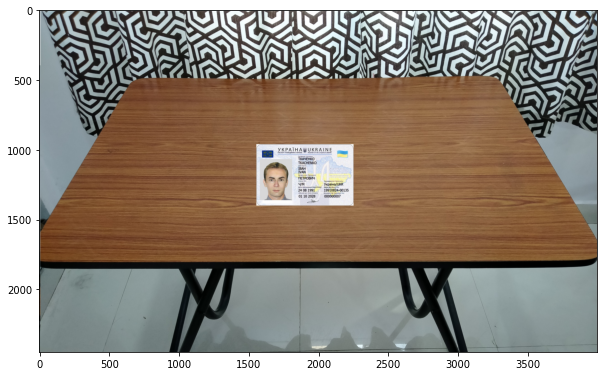

In [1]:
import matplotlib.pyplot as plt

def show_image(image):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(image)

image = plt.imread('./test_passport.jpg')
show_image(image)

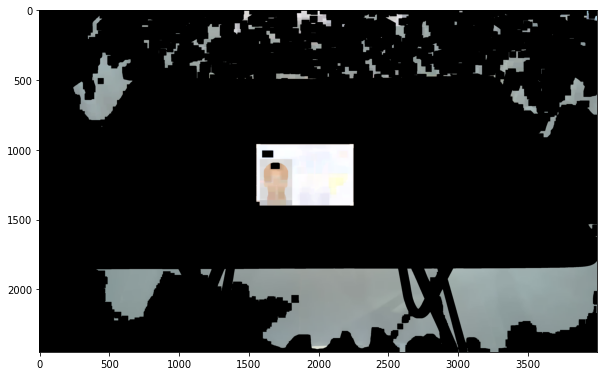

In [2]:
import cv2
import numpy as np

def remove_noise(image):
    kernel = np.ones((5,5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=5)

def background_removal(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    pixels = 10
    rect = (pixels, pixels, image.shape[1] - pixels, image.shape[0] - pixels)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 3, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    return image*mask2[:, :, np.newaxis] 

def additional_noise_removal(image):
    kernel = np.ones((5,5), np.uint8)
    processed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=10)
    processed_image = cv2.GaussianBlur(processed_image, (5, 5), 0)

    gray_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
    threshold_value = 150
    _, mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    return cv2.bitwise_and(processed_image, processed_image, mask=mask)

noiseless_image = remove_noise(image)
foreground_image = background_removal(noiseless_image)
processed_image = additional_noise_removal(foreground_image)
show_image(processed_image)

In [3]:
def find_contours(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blured_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    canny_edges = cv2.Canny(blured_image, 200, 250)
    contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return sorted(contours, key=cv2.contourArea, reverse=True)

def find_corners(contours):
    corners = None
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approximation) == 4:
            corners = approximation
            break
    return corners


In [4]:
def rearange_corners(corners):
    # Rearrange coordinates to order:
    # top-left, top-right, bottom-right, bottom-left
    corners = corners.reshape((4, 2))
    rearanged = np.zeros((4, 2), dtype="float32")
    sum = corners.sum(axis=1)
    rearanged[0] = corners[np.argmin(sum)]
    rearanged[2] = corners[np.argmax(sum)]
    diff = np.diff(corners, axis=1)
    rearanged[1] = corners[np.argmin(diff)]
    rearanged[3] = corners[np.argmax(diff)]
    return rearanged

def destination_corners(corners):
    (tl, tr, br, bl) = corners
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    height = max(int(heightA), int(heightB))
    return np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]], dtype="int32")

def transform_image(image, corners):
    rearanged_corners = rearange_corners(corners)
    destination = destination_corners(rearanged_corners)

    transformed = cv2.getPerspectiveTransform(np.float32(rearanged_corners), np.float32(destination))
    return cv2.warpPerspective(image, transformed, (destination[2][0], destination[2][1]))


In [5]:
def draw_contours(image, corners):
    image_copy = image.copy()
    cv2.drawContours(image_copy, [corners], 0, (0, 255, 0), 5)

    for point in corners:
        cv2.drawMarker(image_copy, tuple(point[0]), (255, 0, 0), markerSize=20, thickness=5)
    return image_copy


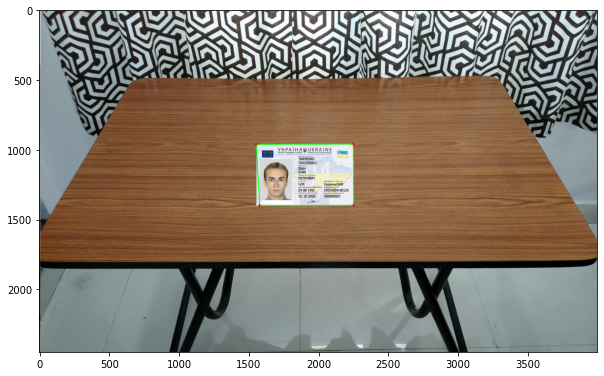

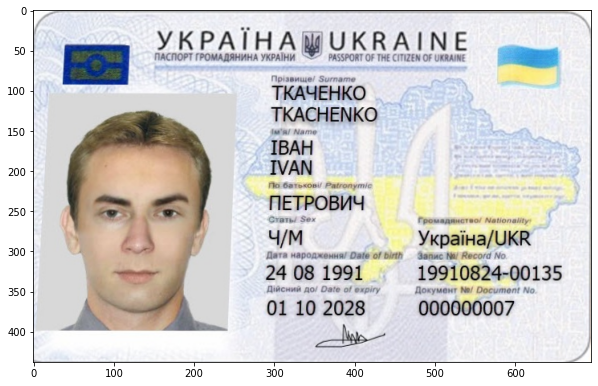

In [6]:
contours = find_contours(processed_image)
corners = find_corners(contours)
if corners is None:
    print("The algorithm failed to detect the corners of the document.")
else:
    image_with_contours = draw_contours(image, corners)
    show_image(image_with_contours)

    transformed_image = transform_image(image, corners)
    show_image(transformed_image)